In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [38]:
#https://storage.googleapis.com/tf-datasets/titanic/train.csv
#https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/train.csv"
eval_file = "./data/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)
print(len(train_df))
print(len(eval_df))
print(train_df.head())  # head() 默认取前５条数据

627
264
   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [5]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

train_df.describe()


,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


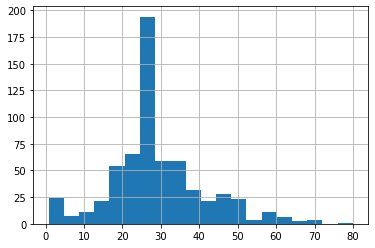

In [6]:
train_df.age.hist(bins=20)

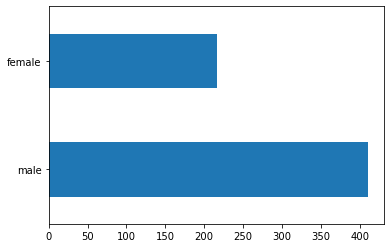

In [7]:
train_df.sex.value_counts().plot(kind="barh")  # barh横向柱状图，  barv纵向柱状图


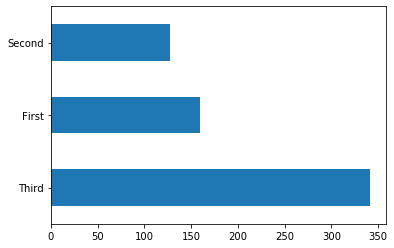

In [8]:
train_df['class'].value_counts().plot(kind="barh")

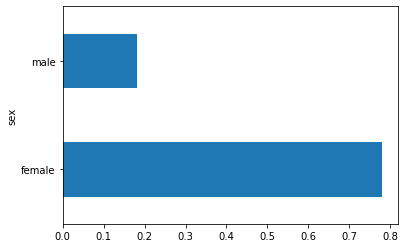

In [10]:
pd.concat([train_df, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [31]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for cc in categorical_columns:
    vocab = train_df[cc].unique()
    print(cc, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column( # indicator_column: can do one hot
            tf.feature_column.categorical_column_with_vocabulary_list(
                cc, vocab
            )
        )
    )
    
for cc in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            cc, dtype=tf.float32
        )
    )

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [32]:
def make_dataset(data_df, label_df, epochs = 10, shuffle=True, batch_size =32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df)
    )
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [33]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [34]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=321, shape=(5,), dtype=string, numpy=array([b'female', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=313, shape=(5,), dtype=float64, numpy=array([25., 17., 28., 24., 32.])>, 'n_siblings_spouses': <tf.Tensor: id=319, shape=(5,), dtype=int32, numpy=array([1, 1, 0, 1, 0], dtype=int32)>, 'parch': <tf.Tensor: id=320, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=318, shape=(5,), dtype=float64, numpy=array([ 7.925, 57.   ,  7.25 , 16.1  ,  8.05 ])>, 'class': <tf.Tensor: id=315, shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'Third', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=316, shape=(5,), dtype=string, numpy=array([b'unknown', b'B', b'unknown', b'unknown', b'E'], dtype=object)>, 'embark_town': <tf.Tensor: id=317, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone

In [35]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[19.]
 [31.]
 [42.]
 [30.]
 [31.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [36]:
 for x, y in train_dataset.take(1):
        print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 31.       1.       0.       0.       1.       0.       0.       0.
    0.       0.       0.       1.       0.       0.       0.       1.
    0.       0.     113.275    1.       0.       0.       0.       0.
    0.       0.       1.       0.       0.       0.       0.       0.
    0.       1.    ]
 [ 25.       1.       0.       0.       1.       0.       0.       1.
    0.       0.       0.       0.       0.       0.       1.       0.
    0.       0.     151.55     1.       0.       0.       0.       

In [41]:
 model = keras.models.Sequential([
     keras.layers.DenseFeatures(feature_columns),
     keras.layers.Dense(20, activation="relu"),
     keras.layers.Dense(20, activation="relu"),
     keras.layers.Dense(2, activation='softmax')
 ])
    
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=["accuracy"]
             )

In [39]:
# 1. model.fit
# 2. model-> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs=100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
history = model.fit(train_dataset, validation_data=eval_dataset,
                   steps_per_epoch=627 // 32,
                   validation_steps=264 // 32,
                   epochs=30)





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 19 steps, validate for 8 steps
Epoch 1/30
19/19 [==============================] - 2s 88ms/step - loss: 2.0943 - accuracy: 0.6118 - val_loss: 1.1429 - val_accuracy: 0.6250
Epoch 2/30
19/19 [==============================] - 0s 5ms/step - loss: 0.7653 - accuracy: 0.6234 - val_loss: 0.6535 - val_accuracy: 0.6250
Epoch 3/30
19/19 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.6464 - val_loss: 0.6289 - val_accuracy: 0.6836
Epoch 4/30
19/19 [============================

In [42]:
estimator = keras.estimator.model_to_estimator(model)
# about: input_fn
# 1. function
# 2. return a. (features, labels) b.dataset -> (feature, label)
estimator.train(input_fn=lambda : make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9zgd0q53', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3d6038c890>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:ten

KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_3', 'input_4', 'input_7', 'input_9', 'input_1', 'input_5', 'input_8', 'input_2', 'input_10', 'input_6'}\n\tfeatures keys: {'parch', 'class', 'age', 'alone', 'sex', 'n_siblings_spouses', 'survived', 'deck', 'embark_town', 'fare'}\n\tDifference: {'age', 'alone', 'sex', 'input_5', 'n_siblings_spouses', 'survived', 'input_3', 'input_8', 'deck', 'input_6', 'class', 'fare', 'parch', 'input_4', 'input_7', 'input_9', 'input_1', 'input_2', 'embark_town', 'input_10'}"